In [1]:
from min30_LSTM_conv_znBinomial import *
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure
from PIL import Image
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot
from Utils.eval import *
from tensorflow.keras.optimizers import Adam
import keras.backend.tensorflow_backend
from keras.backend import clear_session
from tensorflow.keras.models import Model,Sequential
import os

Num GPUs: 1


Using TensorFlow backend.


In [2]:
source_model,checkpoint,modelpath,train,test = getModel()
#source_model,modelpath,train,test = getModel(True)
history_path = os.path.join(modelpath,MODELNAME+"_history")
laststate = getBestState(modelpath,history_path)
epoch = laststate["epoch"]
source_model.load_weights(laststate["modelpath"])
test.setWiggle_off()
#loss = source_model.evaluate(x=test, verbose=1)
#print("Restored model, loss: {:5.5f}".format(loss))

predictions = source_model.layers[-2].output
model = Model(inputs=source_model.inputs, outputs=predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 5)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 96, 96, 5)    230         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 96, 5)    30          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 96, 5)    230         input_1[0][0]                    
______________________________________________________________________________________________

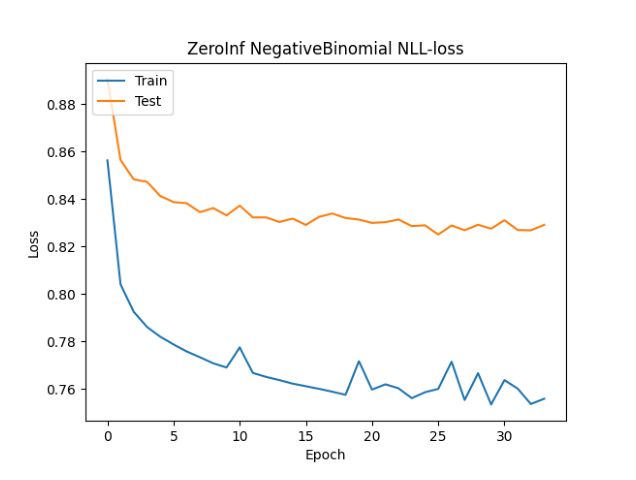

In [3]:
history_path = os.path.join(modelpath,MODELNAME+"_history.png")
figure(num=None, figsize=(10, 30), dpi=80, facecolor='w', edgecolor='k')
loss = np.array(Image.open(history_path))
plt.imshow(loss)
plt.axis('off')
plt.show()
y_transform = [cutOut([16,80,16,80])]


In [4]:
def getFreshSet(batch_size=1):
    y_transform = [cutOut([16,80,16,80])]
    train,test = getData(batch_size,
                         DIMENSION,CHANNELS,
                         timeToPred=30,
                         y_transform=y_transform)
    return train,test

In [5]:
output_dist = tfp.layers.DistributionLambda(
        name="DistributionLayer",
        make_distribution_fn=lambda t: tfp.distributions.Independent(
        tfd.Mixture(
            cat=tfd.Categorical(tf.stack([1-tf.math.sigmoid(t[...,:1]), tf.math.sigmoid(t[...,:1])],axis=-1)),
            components=[tfd.Deterministic(loc=tf.zeros_like(t[...,:1])),
            tfp.distributions.NegativeBinomial(
            total_count=tf.math.softplus(t[..., 1:2]), 
            logits=tf.math.sigmoid(t[..., 2:]) ),])
        ,name="ZeroInflated_Binomial",reinterpreted_batch_ndims=0 ))


pred = None
label = None
pred = 20
test.on_epoch_end()
mean = []
stdev = []
label = []
predictions = []
train,test = getFreshSet(50)
#test.on_epoch_end()
test.setWiggle_off()
atm = []
for x,y in test:
    for i in range(BATCH_SIZE):
        if y[i,:,:,:].max() >= 0:
            pred = model(np.array([x[i,:,:,:]]))
            pred = output_dist(pred)
            mean.append(pred.mean())
            stdev.append(pred.stddev())
            label.append(y[i,:,:,:])
            predictions.append((pred,y[i:,:,:]))
            atm.append(x[i,:,:,-1:])
            if len(label) == 20:
                break
    break
    if len(label) == 20:
                break

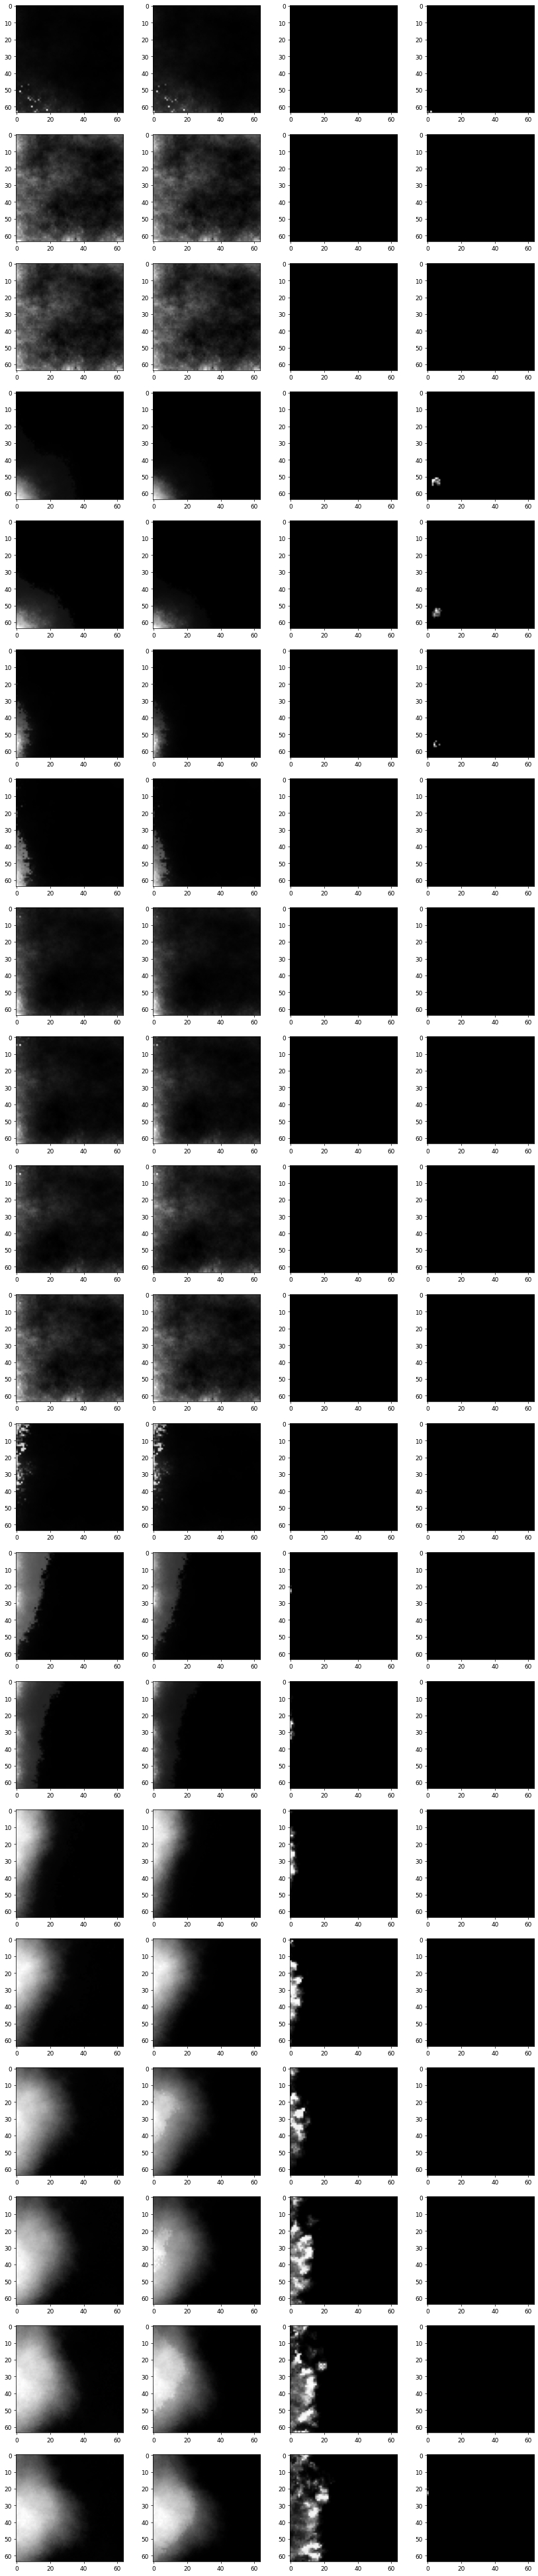

In [6]:
fig, axes = plt.subplots(20, 4, figsize=(16,8*10),dpi=64)

for batch,img in enumerate(mean):
    if batch == 20:
        break
    axes[batch,1].imshow(img[0,:,:,0],cmap="gray")
    axes[batch,0].imshow(stdev[batch][0,:,:,0],cmap="gray")
    axes[batch,2].imshow(label[batch][:,:,0],cmap="gray")
    axes[batch,3].imshow(y_transform[0](atm[batch][:,:,-1]),cmap="gray")
plt.show()

In [7]:
train,test =  getFreshSet(batch_size=100) 
baseline = multiProc_eval(model,test,getFreshSet,x_transform=y_transform)

Worker  0 finishedd   2200 images
Worker  1 finishedd   2200 images
Worker  2 finishedd   2200 images
Worker  3 finishedd   2200 images
Worker  4 finishedd   2200 images
Worker  5 finishedd   2200 images
Worker  6 finishedd   2200 images
Worker  7 finishedd   2200 images
Worker  8 finishedd   2200 images
Worker  9 finishedd   2200 images
Worker 10 finishedd   2200 images
Worker 11 finishedd   2200 images
Worker 12 finishedd   2200 images
Worker 13 finishedd   2200 images
Worker 14 finishedd   2200 images
Worker 15 finishedd   2200 images
Worker 16 finishedd   2200 images
Worker 17 finishedd   2200 images
Worker 18 finishedd   2200 images
Worker 19 finishedd   2200 images
Worker 20 finishedd   2200 images
Worker 21 finishedd   2200 images
Worker 22 finishedd   2200 images
Worker 23 finishedd   2200 images
Worker 24 finishedd   2200 images
Worker 25 finishedd   2200 images
Worker 26 finishedd   2200 images
Worker 27 finishedd   2200 images
Worker 28 finishedd   2200 images
Worker 29 fini

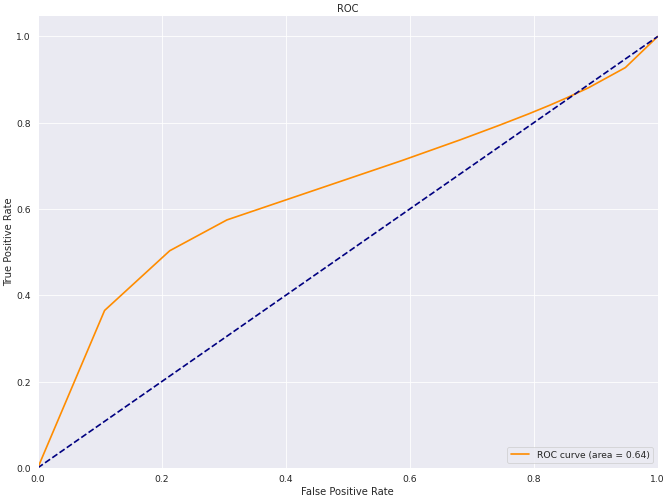

In [8]:
baseline_dict = baseline.copy()


def plotAUC(baseline_dict,lw=3):
    from sklearn.metrics import roc_curve, auc
    
    figure(num=None, figsize=(20, 15), dpi=40, facecolor='w', edgecolor='k')
    tp = []
    fp = []
    
    for key in baseline_dict:
        base = baseline_dict[key]
        tp.append(base["TP"]/(base["TP"]+base["FN"]) )
        fp.append(base["FP"]/(base["FP"]+base["FN"]))
    sns.set(style="ticks", context="talk")
    sns.set_style("darkgrid")
    plt.plot(fp, tp, color='darkorange',
         lw=lw, label='ROC curve (area = {:.2f})'.format(auc(fp,tp)))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()


plotAUC(baseline_dict)

In [9]:

savepath = os.path.join(modelpath,"baselinedict.json")
import json

d = {0: {'TP': 60316923.0, 'TN': 0.0, 'FP': 363209477.0, 'FN': 0.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}, 1: {'TP': 60316923.0, 'TN': 0.0, 'FP': 363209477.0, 'FN': 0.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}, 2: {'TP': 55971744.0, 'TN': 284193228.0, 'FP': 79016249.0, 'FN': 4345179.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}, 3: {'TP': 53155220.0, 'TN': 306068524.0, 'FP': 57140953.0, 'FN': 7161703.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}, 4: {'TP': 51724291.0, 'TN': 313325957.0, 'FP': 49883520.0, 'FN': 8592632.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}, 5: {'TP': 50682556.0, 'TN': 317618920.0, 'FP': 45590557.0, 'FN': 9634367.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}, 6: {'TP': 49490489.0, 'TN': 321952367.0, 'FP': 41257110.0, 'FN': 10826434.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}, 7: {'TP': 47900676.0, 'TN': 326918545.0, 'FP': 36290932.0, 'FN': 12416247.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}, 8: {'TP': 45856574.0, 'TN': 332199127.0, 'FP': 31010350.0, 'FN': 14460349.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}, 9: {'TP': 42942822.0, 'TN': 338436898.0, 'FP': 24772579.0, 'FN': 17374101.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}, 10: {'TP': 34585259.0, 'TN': 352005597.0, 'FP': 11203880.0, 'FN': 25731664.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}, 11: {'TP': 30248583.0, 'TN': 355173560.0, 'FP': 8035917.0, 'FN': 30068340.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}, 12: {'TP': 21865475.0, 'TN': 358636441.0, 'FP': 4573036.0, 'FN': 38451448.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}, 13: {'TP': 0.0, 'TN': 363209477.0, 'FP': 0.0, 'FN': 60316923.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}, 14: {'TP': 0.0, 'TN': 363209477.0, 'FP': 0.0, 'FN': 60316923.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}, 15: {'TP': 0.0, 'TN': 363209477.0, 'FP': 0.0, 'FN': 60316923.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}, 16: {'TP': 0.0, 'TN': 363209477.0, 'FP': 0.0, 'FN': 60316923.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}, 17: {'TP': 0.0, 'TN': 363209477.0, 'FP': 0.0, 'FN': 60316923.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}, 18: {'TP': 0.0, 'TN': 363209477.0, 'FP': 0.0, 'FN': 60316923.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}, 19: {'TP': 0.0, 'TN': 363209477.0, 'FP': 0.0, 'FN': 60316923.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}, 20: {'TP': 0.0, 'TN': 363209477.0, 'FP': 0.0, 'FN': 60316923.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}, 21: {'TP': 0.0, 'TN': 363209477.0, 'FP': 0.0, 'FN': 60316923.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}, 22: {'TP': 0.0, 'TN': 363209477.0, 'FP': 0.0, 'FN': 60316923.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}, 23: {'TP': 0.0, 'TN': 363209477.0, 'FP': 0.0, 'FN': 60316923.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}, 24: {'TP': 0.0, 'TN': 363209477.0, 'FP': 0.0, 'FN': 60316923.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}, 25: {'TP': 0.0, 'TN': 363209477.0, 'FP': 0.0, 'FN': 60316923.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}, 26: {'TP': 0.0, 'TN': 363209477.0, 'FP': 0.0, 'FN': 60316923.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}, 27: {'TP': 0.0, 'TN': 363209477.0, 'FP': 0.0, 'FN': 60316923.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}, 28: {'TP': 0.0, 'TN': 363209477.0, 'FP': 0.0, 'FN': 60316923.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}, 29: {'TP': 0.0, 'TN': 363209477.0, 'FP': 0.0, 'FN': 60316923.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}, 30: {'TP': 0.0, 'TN': 363209477.0, 'FP': 0.0, 'FN': 60316923.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}, 31: {'TP': 0.0, 'TN': 363209477.0, 'FP': 0.0, 'FN': 60316923.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}, 32: {'TP': 0.0, 'TN': 363209477.0, 'FP': 0.0, 'FN': 60316923.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}, 33: {'TP': 0.0, 'TN': 363209477.0, 'FP': 0.0, 'FN': 60316923.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}, 34: {'TP': 0.0, 'TN': 363209477.0, 'FP': 0.0, 'FN': 60316923.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}, 35: {'TP': 0.0, 'TN': 363209477.0, 'FP': 0.0, 'FN': 60316923.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}, 36: {'TP': 0.0, 'TN': 363209477.0, 'FP': 0.0, 'FN': 60316923.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}, 37: {'TP': 0.0, 'TN': 363209477.0, 'FP': 0.0, 'FN': 60316923.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}, 38: {'TP': 0.0, 'TN': 363209477.0, 'FP': 0.0, 'FN': 60316923.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}, 39: {'TP': 0.0, 'TN': 363209477.0, 'FP': 0.0, 'FN': 60316923.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}, 40: {'TP': 0.0, 'TN': 363209477.0, 'FP': 0.0, 'FN': 60316923.0, 'TP_simple': 33308603.0, 'TN_simple': 335590946.0, 'FP_simple': 27618531.0, 'FN_simple': 27008320.0, 'total': 423526400, 'rain total': 363209477}}

with open(savepath,"w") as f:
    json.dump(d,f)


In [ ]:

ret = calculate_quantiles(model,test,cfdi=99)
q,l = ret

In [ ]:
def plotCFDI(q,l):
    x,y = np.random.randint(low=0,high=q[0].shape[1],size=2)
    
    lower = []
    upper = []
    mean  = []
    label = []
    
    for i in range(len(q)):
        lower.append(q[i][0,x,y,0])
        mean.append(q[i][0,x,y,1])
        upper.append(q[i][0,x,y,2])
        label.append(l[i][x,y,0])
        
    x = np.arange(len(lower))
    
    sns.set(style="darkgrid")
    plt.figure(figsize=(20, 10),dpi=100)
    fig, ax = plt.subplots(1, 1,figsize=(20, 10),dpi=100, sharex=True)
    
    size=25
    lw = 2
    params = {'legend.fontsize': 'x-large',
              'figure.figsize': (20,8),
              'axes.labelsize': size,
              'axes.titlesize': size,
              'xtick.labelsize': size,
              'ytick.labelsize': size,
              'axes.titlepad': 25}
    plt.rcParams.update(params)
    
    ax.plot(x, lower,color='black',label="x >= 0.05",alpha = 0.5,lw=lw)
    ax.plot(x, upper, color='black',label="0.95 >=x",alpha = 0.5,lw=lw)
    ax.plot(x, label, color='red',label="True",alpha = 0.5,lw=lw)
    ax.plot(x, mean, color='blue',label="mean",alpha = 0.5,lw=lw)
    plt.legend(loc="upper right")
    ax.fill_between(x, lower, upper, where=upper >= lower, facecolor='green', alpha=0.1,interpolate=True)
    ax.set_title('Konfidenzintervall')
    plt.ylim([0.0, np.max( (np.max(label),np.max(upper)) )])
    plt.xlim([0, len(q)])
    plt.ylabel('Label')
    plt.xlabel('Zeitpunkt')
plotCFDI(q[0:100],l[0:100])


In [ ]:
hist,hist_q = histogramm(q,l)

In [ ]:
def plotHist(hist,hist_q):
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib import colors
    from matplotlib.ticker import PercentFormatter
    sns.set(style="darkgrid")
    plt.figure(figsize=(20, 10),dpi=100)

    size=20
    lw = 3
    params = {'legend.fontsize': 'x-large',
              'figure.figsize': (20,8),
              'axes.labelsize': size,
              'axes.titlesize': size,
              'xtick.labelsize': size,
              'ytick.labelsize': size,
              'axes.titlepad': 25}
    plt.rcParams.update(params)
    
    hist_n = hist / hist[1:50].sum()
    plt.title('Liegt im Konvidenzintervall')
    plt.bar(np.arange(1,51),hist_n[1:51],color="red",alpha=0.5,lw=.1,label="True")
    plt.ylim([0.0, 0.2])
    plt.xlim([0, 50])
    plt.xlabel('Label')
    plt.ylabel('relative Häufigkeit')
    #plt.show()

    hist_q_n = hist_q / hist[1:50].sum()
    plt.bar(np.arange(1,51),hist_q_n[1:51],color="blue",alpha=0.5,lw=.1,label="Prediction im Bereich")
    plt.ylim([0.0, 0.2])
    plt.xlim([0, 50])
    plt.legend(loc="upper right")
    plt.show()


plotHist(hist,hist_q)

In [12]:
someStats(hist,hist_q)

Anzahl an labels           : 1024000.0
Anzahl liegt im C-Intervall 888391.0 | 0.87:

Ohne Regen
Anzahl an labels           : 132831.0
Anzahl liegt im C-Intervall: 53274.0 | 0.40%


Parameter : 0.50


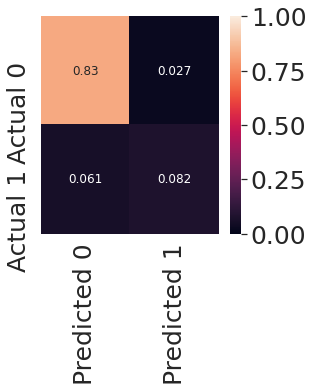

Simple Baseline


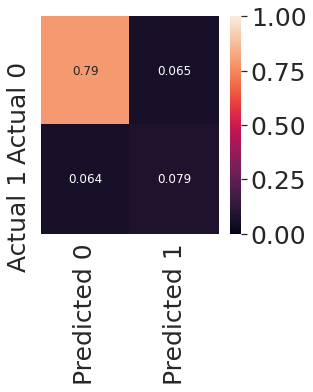

10
41


In [15]:
def plotConfusionMat(baseline,t):
    
    
    print("Parameter : {:.2f}".format(t/20))
    baseline = baseline[t]
    false_neg = baseline["FN"]
    false_pos = baseline["FP"]
    true_pos = baseline["TP"]
    true_neg = baseline["TN"]
    
    simple_false_neg = baseline["FN_simple"]
    simple_false_pos = baseline["FP_simple"]
    simple_true_pos = baseline["TP_simple"]
    simple_true_neg = baseline["TN_simple"]
    
    
    plt.figure(figsize = (4,4))

    #mat = np.array([[false_neg.sum(),false_pos.sum()],[true_neg.sum(),true_pos.sum()]])
    mat = np.array([[true_neg.sum(),false_pos.sum()],[false_neg.sum(),true_pos.sum()]])
    total = mat.sum()
    df_cm = pd.DataFrame(mat/total,index = ["Actual 0","Actual 1"],columns=["Predicted 0","Predicted 1"])
    sns.heatmap(df_cm, annot=True,vmin=0.0, vmax=1.0)
    plt.show()
    
    plt.figure(figsize = (4,4))
    print("Simple Baseline")
    mat_simple = np.array([[simple_true_neg.sum(),simple_false_pos.sum()],[simple_false_neg.sum(),simple_true_pos.sum()]])
    total = mat.sum()
    df_cm = pd.DataFrame(mat_simple/total,index = ["Actual 0","Actual 1"],columns=["Predicted 0","Predicted 1"])
    sns.heatmap(df_cm, annot=True,vmin=0.0, vmax=1.0)
    plt.show()

    print(len(baseline))
    
plotConfusionMat(baseline_dict,t=10)

    
print(len(baseline))

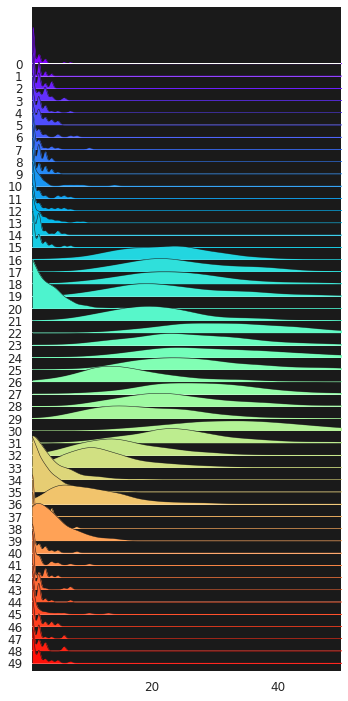

In [16]:

def getDist(param,dist,iv=(0,255)):
    prediction = dist(param)
    prob = np.array(prediction.sample(255))
    prob = prob.transpose(1,2,3,4,0)
    
    return prob[:,:,:,0,:]
    

def joyplot(model,test,max_j = 2):
    y = test[0][1]
    x_,y_ = np.random.randint(low=0,high=y.shape[1],size=2)

    dists = []
    time_d  = []
    x_series = []

    for j,(x,y) in enumerate(test):
        
        if j >= max_j:
            break
        batch_size = x.shape[0]
        for i in range(batch_size):
            pred = model(np.array([x[i,:,:,:]]))
            d = getDist(pred[:,:,:,:],nBinom)
            dists.append(np.array(d[0,x_,y_,:]))
            x_series.append(np.arange(0,255))
            
    import joypy
    dframe = pd.DataFrame(np.array(dists[:50]).T)
    fig, axes = joypy.joyplot(dframe,
                              figsize=(5,10),
                              linewidth=0.5,
                              grid='y',
                              background='k',
                              x_range=[1,50],
                              colormap=cm.rainbow)

joyplot(model,test)

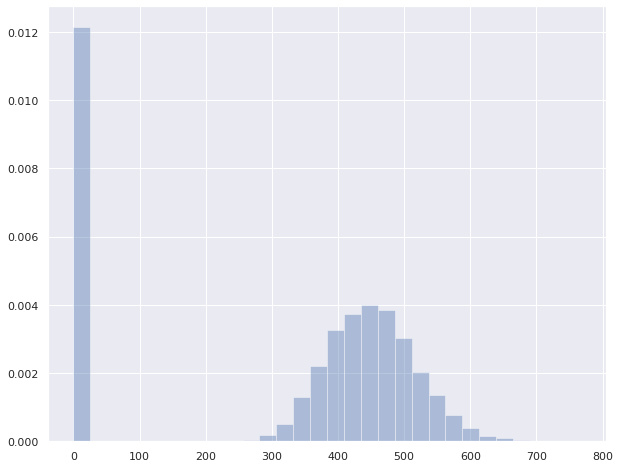

In [17]:
import tensorflow_probability as tfp
import seaborn as sns
import numpy as np
tfd = tfp.distributions
dist = tfd.Mixture(
            cat=tfd.Categorical([0.1,0.9]),
            components=[tfd.Deterministic(loc=0),
            tfp.distributions.NegativeBinomial(
            total_count=50, 
            probs=0.9),])


y = dist.sample(16000)

sns.set(color_codes=True)
sns.set_color_codes()
sns.set(rc={'figure.figsize':(10,8)})
sns.distplot(y,
             bins=30,
            norm_hist=True,kde=False,rug=False)




In [18]:
from Utils.transform import LogBin
logbin = LogBin()
q_a = []
l_a = []




train,test =  getFreshSet(batch_size=1) 
for j,(x,y) in enumerate(test):
    batch_shape = x.shape[0]
    pred = model(x)
    pred = output_dist(pred)
    l_a.append(logbin(y))
    
    p = np.array(pred.mean())
    p[np.where(p < 1)] = 0
    
    q_a.append(logbin(p))
    print(j,end="\r")
    if j == 2500:
        break

In [19]:
def histogramm(q,l,last=3,m_labels=256):
    _,x,y,_ = q[0].shape
    
    hist = np.zeros(m_labels)
    hist_q = hist.copy()
        
    for i,d in enumerate(q):
        label = l[i]
        label = label.ravel()
        d = d.reshape(x*y,last)
        for j in range(x*y):
            hist[int(label[j])] += 1
            v = label[j]
            if d[j][0] <= v and d[j][-1] >= v:
                hist_q[int(label[j])] += 1
    return hist,hist_q
hist,hist_q = histogramm(q_a,l_a,last=1,m_labels=7)

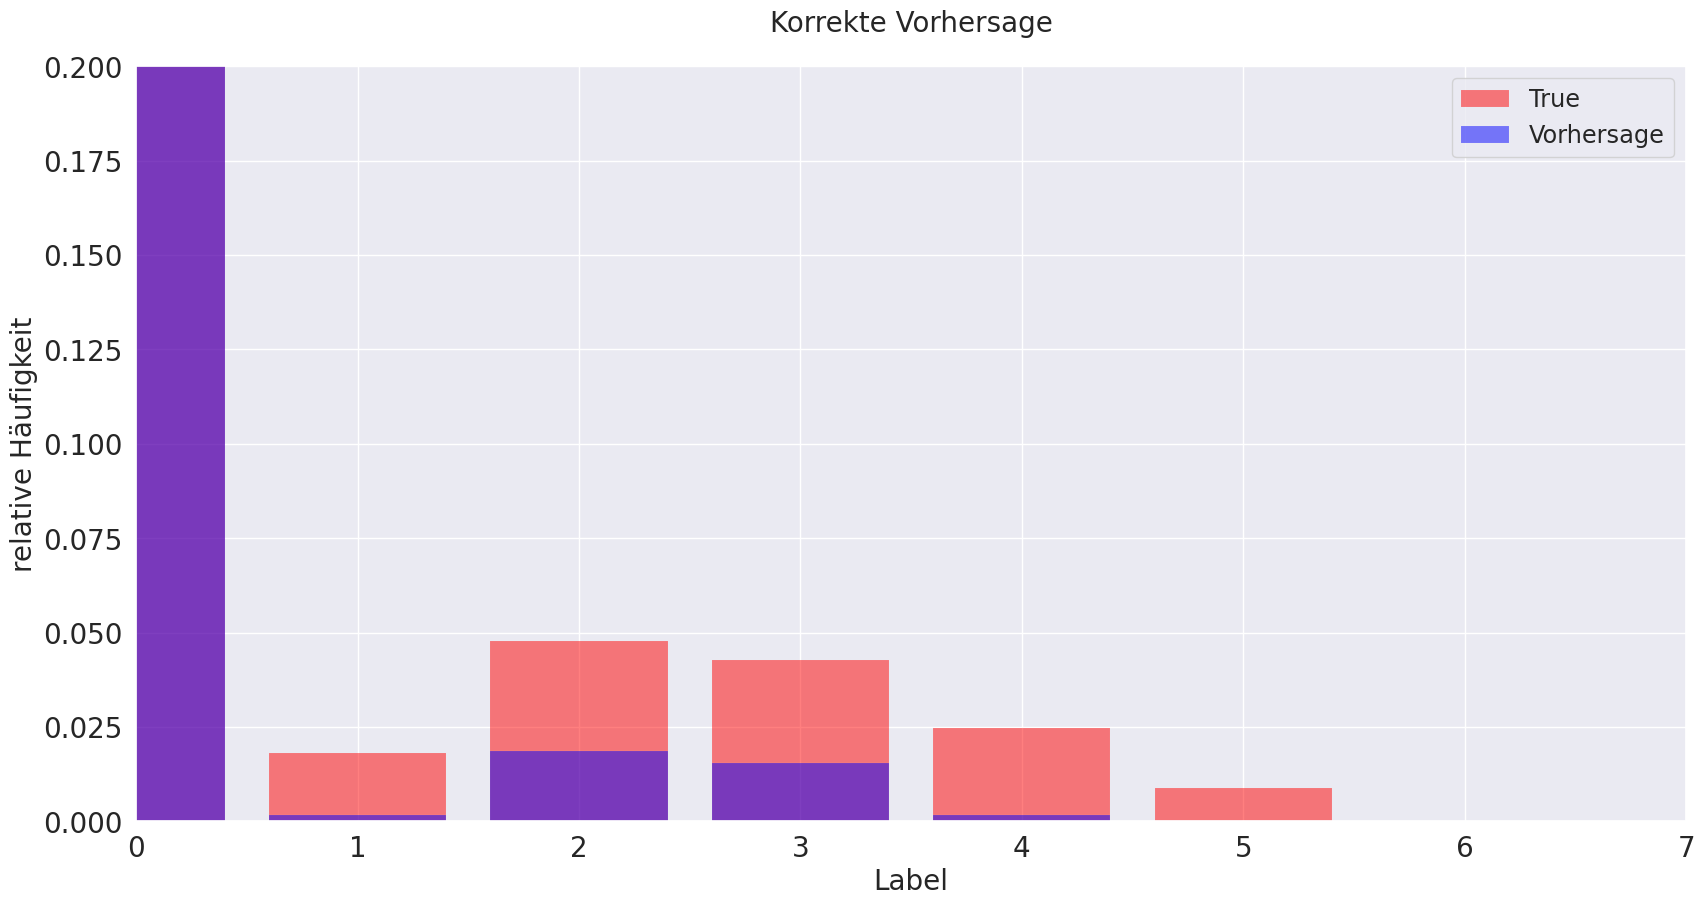

In [22]:
def plotHist(hist,hist_q,min_ = 1,max_=50,title='Liegt im Quantil'):
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib import colors
    from matplotlib.ticker import PercentFormatter
    sns.set(style="darkgrid")
    plt.figure(figsize=(20, 10),dpi=100)
    
    size=20
    lw = 3
    params = {'legend.fontsize': 'x-large',
              'figure.figsize': (20,8),
              'axes.labelsize': size,
              'axes.titlesize': size,
              'xtick.labelsize': size,
              'ytick.labelsize': size,
              'axes.titlepad': 25}
    plt.rcParams.update(params)
    hist_n = hist / hist[min_:max_].sum()
    plt.title(title)
    plt.bar(np.arange(min_,max_+1),hist_n[min_:max_+1],color="red",alpha=0.5,lw=.1,label="True")
    plt.ylim([0.0, 0.2])
    plt.xlim([min_, max_])
    plt.xlabel('Label')
    plt.ylabel('relative Häufigkeit')
    #plt.show()

    hist_q_n = hist_q / hist[min_:max_].sum()
    plt.bar(np.arange(min_,max_+1),hist_q_n[min_:max_+1],color="blue",alpha=0.5,lw=.1,label="Vorhersage")
    plt.ylim([0.0, 0.2])
    plt.xlim([min_, max_+1])
    plt.legend(loc="upper right")
    plt.show()
plotHist(hist,hist_q,min_=0,max_=6,title="Korrekte Vorhersage")

In [21]:
someStats(hist,hist_q)

Anzahl an labels           : 10244096.0
Anzahl liegt im C-Intervall 7947031.0 | 0.78:

Ohne Regen
Anzahl an labels           : 1456797.0
Anzahl liegt im C-Intervall: 384507.0 | 0.26%
